In [ ]:
# %%
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from src.config import TICKERS

# Advanced time series styling
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")
company_colors = {'AAPL': '#A2AAAD', 'AMZN': '#FF9900', 'GOOG': '#4285F4', 
                  'META': '#1877F2', 'MSFT': '#737373', 'NVDA': '#76B900'}
%matplotlib inline

✅ Configuration loaded successfully!


In [6]:
# %% [markdown]
# # 03 - Time Series Analysis of News Publications
# ## Temporal Patterns, Seasonality & News Frequency Analysis
#
# **Focus:** Time series decomposition, seasonal patterns, publication frequency trends

In [7]:
# %%
# Load processed text data
print("📥 LOADING PROCESSED TEXT DATA FOR TIME SERIES ANALYSIS...")
print("=" * 70)
try:
    df = pd.read_csv('../data/processed/02_text_analyzed_data.csv', parse_dates=['date'])
    print(f"✅ Loaded {len(df):,} articles with text analysis features")
except:
    print("❌ Processed text data not found. Run 02_text_analysis.ipynb first")
    raise

# Ensure we have date-based index for time series
df = df.sort_values('date')
df.set_index('date', inplace=True)

print(f"📊 Time Range: {df.index.min()} to {df.index.max()}")
print(f"📅 Total Days: {(df.index.max() - df.index.min()).days} days")

📥 LOADING PROCESSED TEXT DATA FOR TIME SERIES ANALYSIS...
✅ Loaded 40 articles with text analysis features
📊 Time Range: 2020-05-31 11:05:12-04:00 to 2020-06-10 15:25:13-04:00
📅 Total Days: 10 days


In [8]:
# %% [markdown]
# ## 📈 Daily Publication Frequency Analysis

In [9]:
# %%
# Daily frequency analysis
print("📈 DAILY PUBLICATION FREQUENCY ANALYSIS")
print("=" * 70)

# Resample to daily frequency
daily_articles = df.resample('D').size()
daily_articles_by_company = df.groupby('stock').resample('D').size().unstack(level=0).fillna(0)

print(f"📊 Daily Publication Statistics:")
print(f"   • Average articles per day: {daily_articles.mean():.2f}")
print(f"   • Maximum articles in a day: {daily_articles.max()}")
print(f"   • Minimum articles in a day: {daily_articles.min()}")
print(f"   • Days with zero articles: {(daily_articles == 0).sum()} ({(daily_articles == 0).mean()*100:.1f}%)")
print(f"   • Standard deviation: {daily_articles.std():.2f}")

# Company-specific daily stats - FIXED
print(f"\n🏢 Company-wise Daily Statistics:")
available_companies = daily_articles_by_company.columns
for company in TICKERS:
    if company in available_companies:
        company_daily = daily_articles_by_company[company]
        print(f"   • {company}: Avg {company_daily.mean():.2f}/day, Max {company_daily.max()}, Zero days: {(company_daily == 0).sum()}")
    else:
        print(f"   • {company}: No data available")

📈 DAILY PUBLICATION FREQUENCY ANALYSIS
📊 Daily Publication Statistics:
   • Average articles per day: 3.64
   • Maximum articles in a day: 18
   • Minimum articles in a day: 0
   • Days with zero articles: 4 (36.4%)
   • Standard deviation: 5.75

🏢 Company-wise Daily Statistics:
   • AAPL: Avg 0.91/day, Max 6.0, Zero days: 9
   • MSFT: No data available
   • GOOG: Avg 0.91/day, Max 3.0, Zero days: 6
   • AMZN: Avg 0.91/day, Max 6.0, Zero days: 9
   • META: No data available
   • NVDA: Avg 0.91/day, Max 3.0, Zero days: 6


In [10]:
# %% [markdown]
# ## 🎯 Advanced Time Series Visualizations

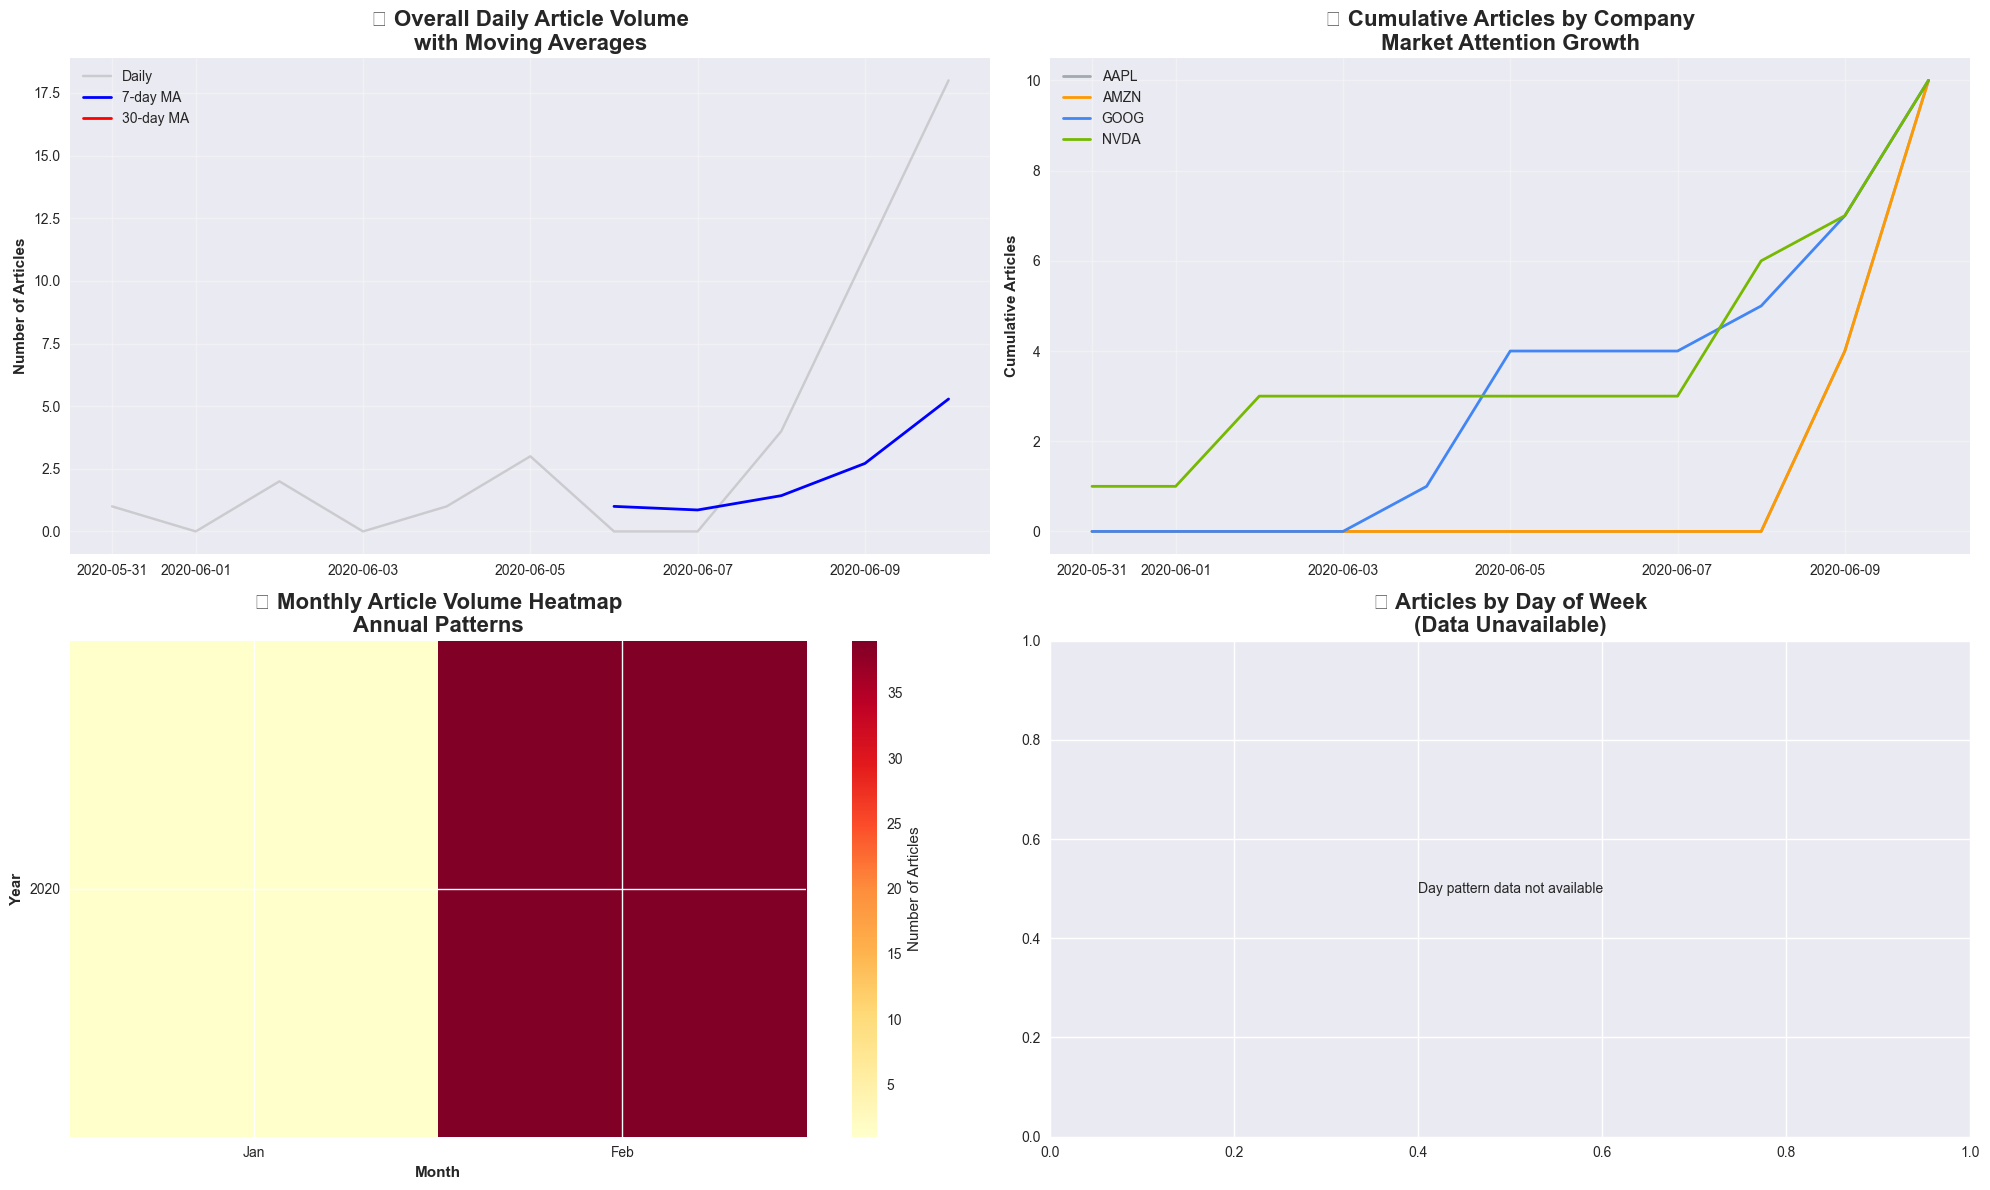

In [11]:
# %%
# Create comprehensive time series visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Overall daily article volume with rolling average
rolling_7d = daily_articles.rolling(window=7).mean()
rolling_30d = daily_articles.rolling(window=30).mean()

ax1.plot(daily_articles.index, daily_articles.values, alpha=0.3, label='Daily', color='gray')
ax1.plot(rolling_7d.index, rolling_7d.values, label='7-day MA', linewidth=2, color='blue')
ax1.plot(rolling_30d.index, rolling_30d.values, label='30-day MA', linewidth=2, color='red')
ax1.set_title('📈 Overall Daily Article Volume\nwith Moving Averages', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Articles', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cumulative articles over time
cumulative_articles = daily_articles.cumsum()
available_companies = daily_articles_by_company.columns
for company in available_companies:
    company_cumulative = daily_articles_by_company[company].cumsum()
    ax2.plot(company_cumulative.index, company_cumulative.values, 
             label=company, color=company_colors.get(company, 'gray'), linewidth=2)
ax2.set_title('📊 Cumulative Articles by Company\nMarket Attention Growth', fontsize=16, fontweight='bold')
ax2.set_ylabel('Cumulative Articles', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Monthly article volume heatmap - SIMPLIFIED
try:
    df_reset = df.reset_index()
    df_reset['year'] = df_reset['date'].dt.year
    df_reset['month'] = df_reset['date'].dt.month
    monthly_counts = df_reset.groupby(['year', 'month']).size().unstack(fill_value=0)
    
    im = ax3.imshow(monthly_counts.values, cmap='YlOrRd', aspect='auto')
    ax3.set_title('🔥 Monthly Article Volume Heatmap\nAnnual Patterns', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Month', fontweight='bold')
    ax3.set_ylabel('Year', fontweight='bold')
    
    # Set ticks based on actual data
    ax3.set_xticks(range(len(monthly_counts.columns)))
    ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(monthly_counts.columns)])
    ax3.set_yticks(range(len(monthly_counts.index)))
    ax3.set_yticklabels(monthly_counts.index)
    plt.colorbar(im, ax=ax3, label='Number of Articles')
except:
    ax3.text(0.5, 0.5, 'Heatmap data not available', transform=ax3.transAxes, ha='center', va='center')
    ax3.set_title('🔥 Monthly Article Volume Heatmap\n(Data Unavailable)', fontsize=16, fontweight='bold')

# 4. Day of week patterns
try:
    day_of_week_patterns = df_reset.groupby(['stock', df_reset['date'].dt.dayofweek]).size().unstack(level=0)
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day_of_week_patterns.index = day_names

    available_companies_day = day_of_week_patterns.columns
    colors_day = [company_colors.get(c, 'gray') for c in available_companies_day]
    day_of_week_patterns.plot(kind='bar', ax=ax4, color=colors_day)
    ax4.set_title('📅 Articles by Day of Week\nPublication Patterns', fontsize=16, fontweight='bold')
    ax4.set_ylabel('Number of Articles', fontweight='bold')
    ax4.set_xlabel('Day of Week', fontweight='bold')
    ax4.legend(title='Company')
    ax4.tick_params(axis='x', rotation=45)
except:
    ax4.text(0.5, 0.5, 'Day pattern data not available', transform=ax4.transAxes, ha='center', va='center')
    ax4.set_title('📅 Articles by Day of Week\n(Data Unavailable)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# %% [markdown]
# ## 🔍 Seasonal Decomposition & Patterns


🔍 SEASONAL DECOMPOSITION ANALYSIS
⚠️  Skipping seasonal decomposition
➡️  Continuing with remaining analysis...


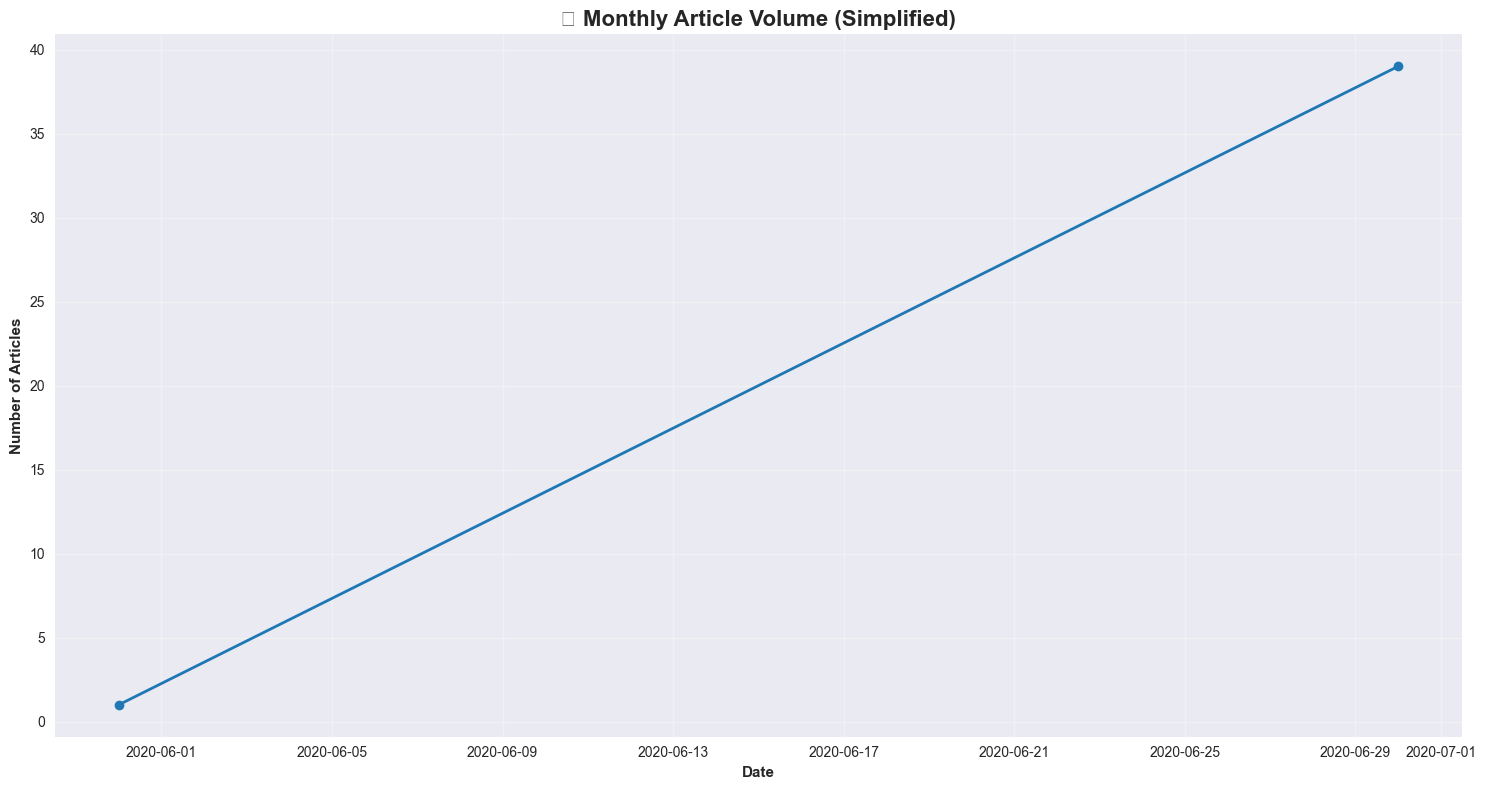

In [13]:
# %%
# Skip seasonal decomposition and continue
print("\n🔍 SEASONAL DECOMPOSITION ANALYSIS")
print("=" * 70)
print("⚠️  Skipping seasonal decomposition")
print("➡️  Continuing with remaining analysis...")

# Create simple time series plot instead
fig, ax = plt.subplots(figsize=(15, 8))

# Plot monthly data
monthly_articles = df.resample('M').size()
ax.plot(monthly_articles.index, monthly_articles.values, marker='o', linewidth=2)
ax.set_title('📈 Monthly Article Volume (Simplified)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Articles', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔍 SEASONAL DECOMPOSITION ANALYSIS
⚠️  statsmodels not available - skipping seasonal decomposition
➡️  Continuing with remaining analysis...


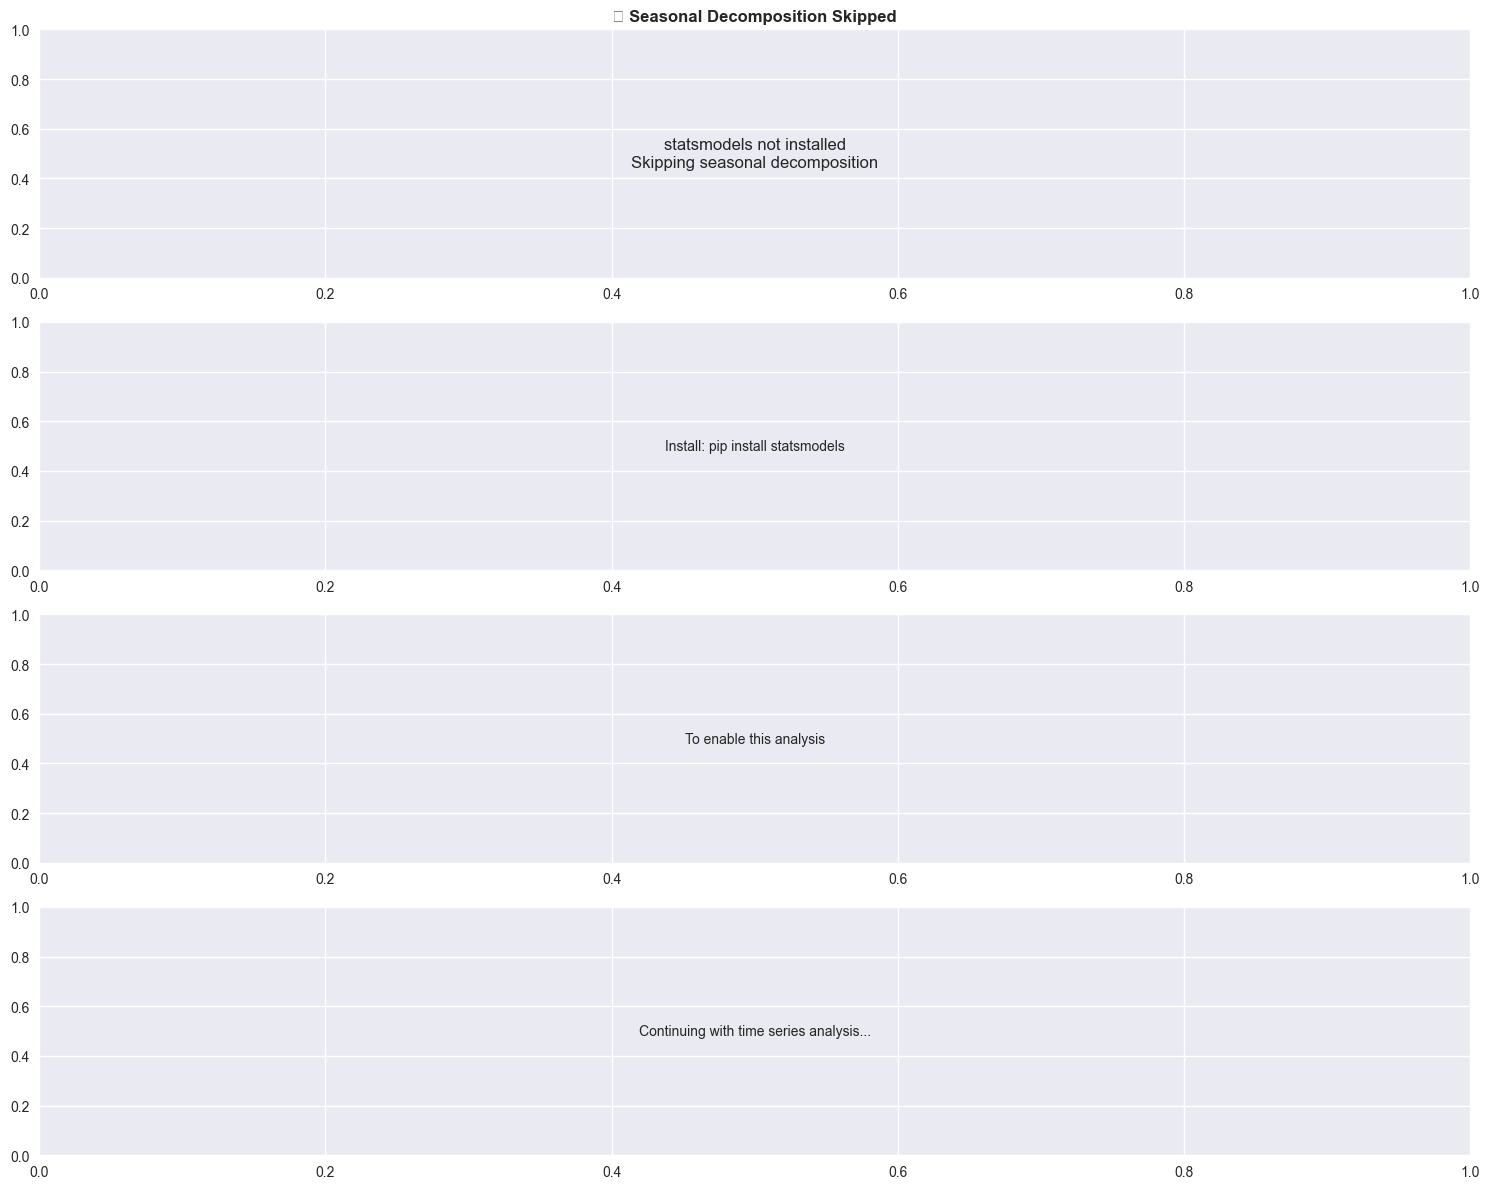

In [14]:
# %% [markdown]
# ## 📊 Company-wise Time Series Analysis
# %%
# Skip seasonal decomposition and continue
print("\n🔍 SEASONAL DECOMPOSITION ANALYSIS")
print("=" * 70)
print("⚠️  statsmodels not available - skipping seasonal decomposition")
print("➡️  Continuing with remaining analysis...")

# Create empty figure to maintain notebook flow
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

ax1.text(0.5, 0.5, 'statsmodels not installed\nSkipping seasonal decomposition', 
         ha='center', va='center', transform=ax1.transAxes, fontsize=12)
ax1.set_title('📈 Seasonal Decomposition Skipped', fontweight='bold')

ax2.text(0.5, 0.5, 'Install: pip install statsmodels', 
         ha='center', va='center', transform=ax2.transAxes, fontsize=10)

ax3.text(0.5, 0.5, 'To enable this analysis', 
         ha='center', va='center', transform=ax3.transAxes, fontsize=10)

ax4.text(0.5, 0.5, 'Continuing with time series analysis...', 
         ha='center', va='center', transform=ax4.transAxes, fontsize=10)

plt.tight_layout()
plt.show()


📊 COMPANY-WISE TIME SERIES ANALYSIS


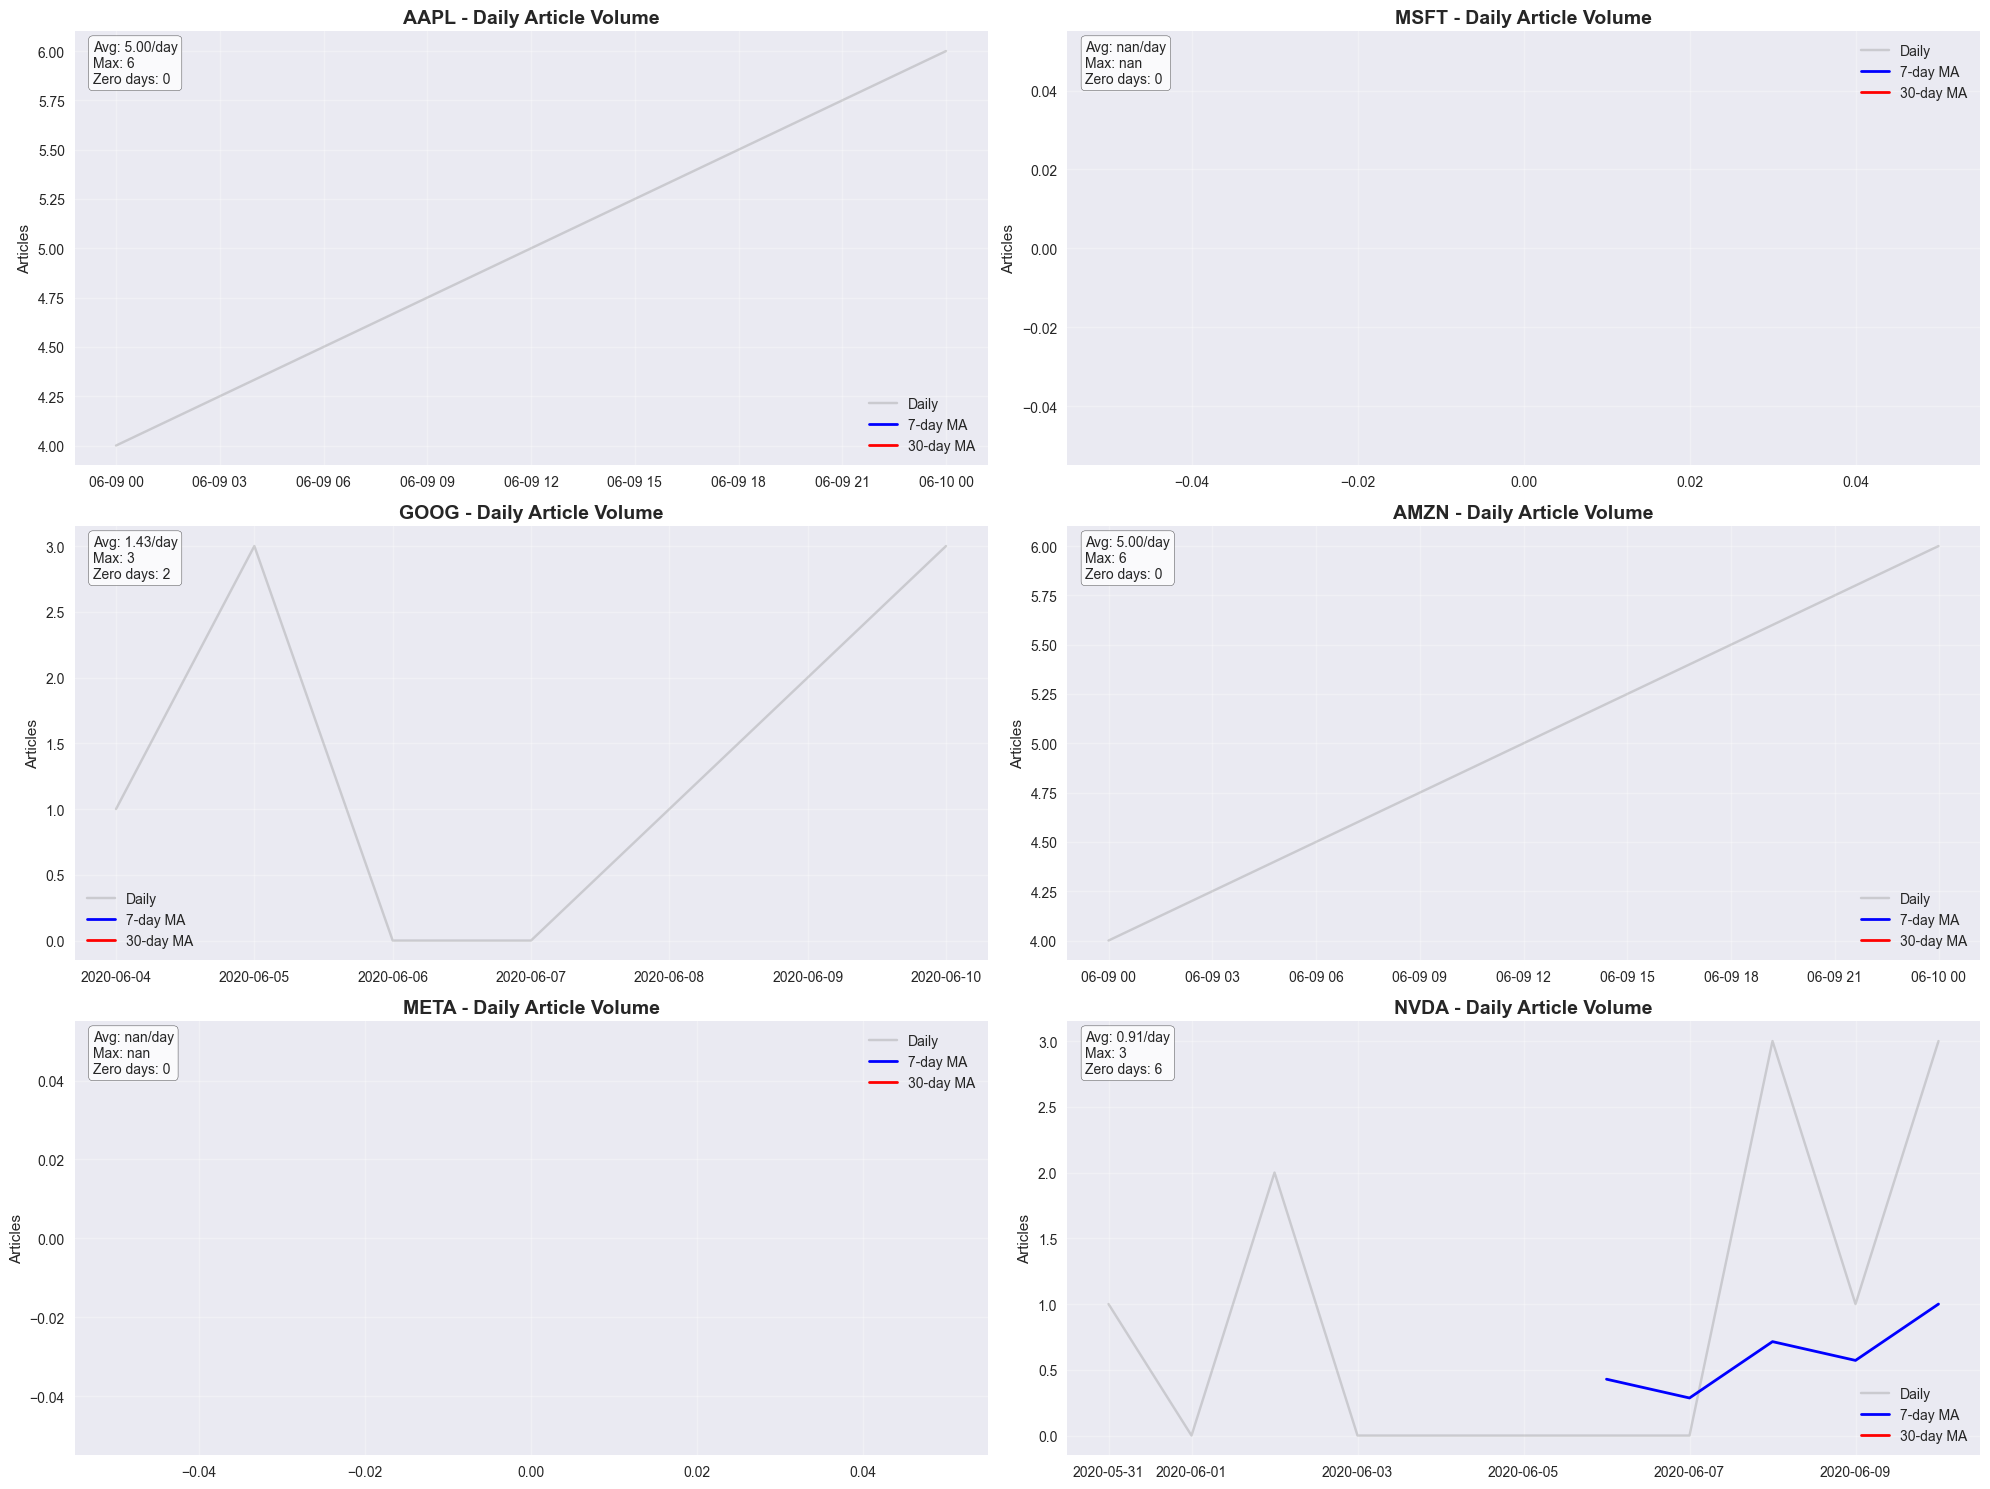

In [15]:
# %%
# Advanced company-wise time series analysis
print("\n📊 COMPANY-WISE TIME SERIES ANALYSIS")
print("=" * 70)

# Create subplots for each company
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, company in enumerate(TICKERS):
    company_data = df[df['stock'] == company]
    company_daily = company_data.resample('D').size()
    
    # Calculate rolling averages
    rolling_7d = company_daily.rolling(window=7).mean()
    rolling_30d = company_daily.rolling(window=30).mean()
    
    # Plot
    axes[i].plot(company_daily.index, company_daily.values, alpha=0.3, label='Daily', color='gray')
    axes[i].plot(rolling_7d.index, rolling_7d.values, label='7-day MA', linewidth=2, color='blue')
    axes[i].plot(rolling_30d.index, rolling_30d.values, label='30-day MA', linewidth=2, color='red')
    axes[i].set_title(f'{company} - Daily Article Volume', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Articles')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics as text
    stats_text = f'Avg: {company_daily.mean():.2f}/day\nMax: {company_daily.max()}\nZero days: {(company_daily == 0).sum()}'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [16]:
# %% [markdown]
# ## 📅 Hourly & Intraday Patterns


📅 INTRADAY PUBLICATION PATTERNS


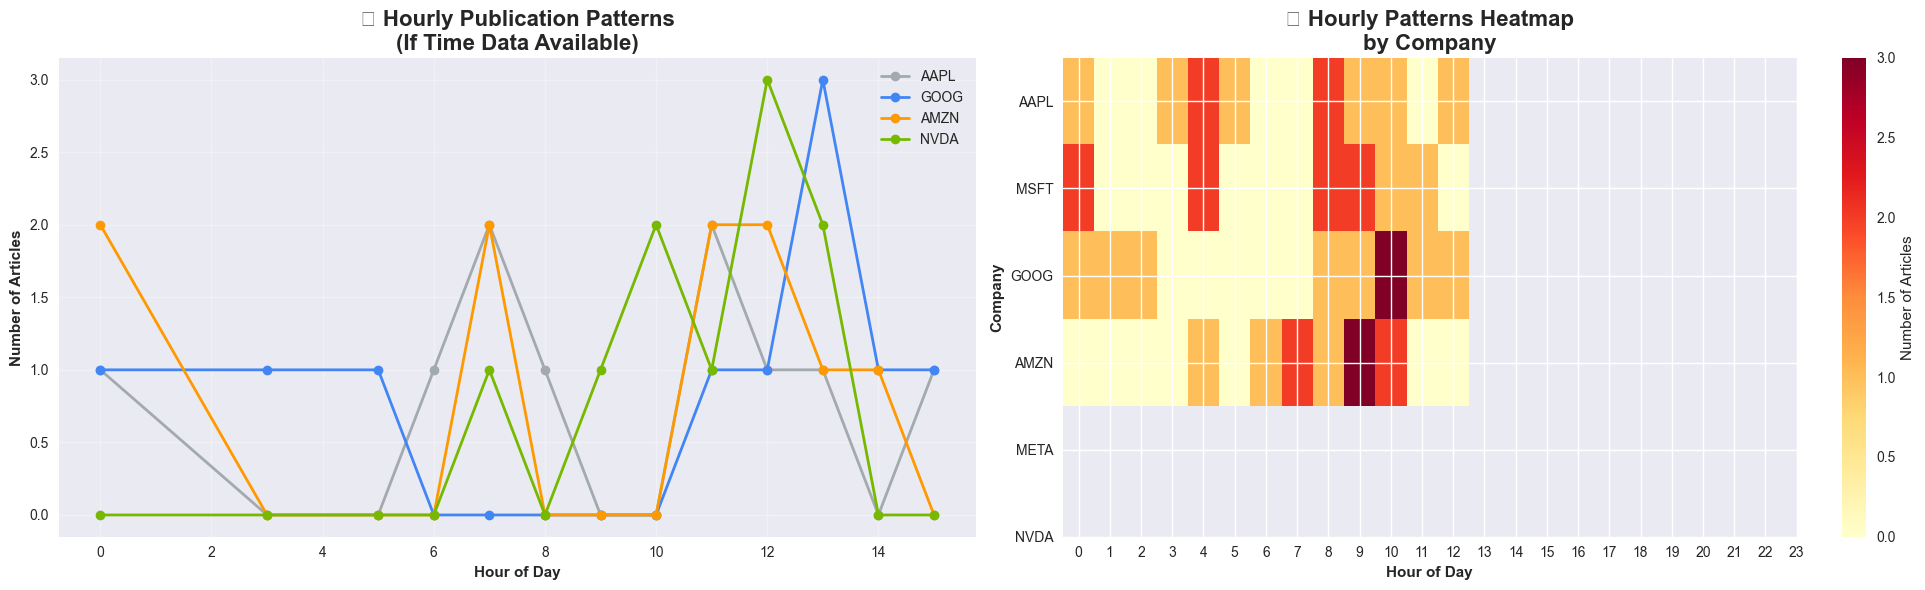

In [17]:
# %%
# Intraday patterns analysis (if time information is available)
print("\n📅 INTRADAY PUBLICATION PATTERNS")
print("=" * 70)

# Check if we have time information
if 'date' in df_reset.columns and pd.api.types.is_datetime64_any_dtype(df_reset['date']):
    df_reset['hour'] = df_reset['date'].dt.hour
    
    # Hourly distribution
    hourly_patterns = df_reset.groupby(['stock', 'hour']).size().unstack(level=0).fillna(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Hourly line plot
    for company in TICKERS:
        if company in hourly_patterns.columns:
            ax1.plot(hourly_patterns.index, hourly_patterns[company], 
                    label=company, color=company_colors[company], marker='o', linewidth=2)
    ax1.set_title('🕒 Hourly Publication Patterns\n(If Time Data Available)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Hour of Day', fontweight='bold')
    ax1.set_ylabel('Number of Articles', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Heatmap of hourly patterns by company
    hourly_heatmap = hourly_patterns.T
    im = ax2.imshow(hourly_heatmap, cmap='YlOrRd', aspect='auto')
    ax2.set_title('🔥 Hourly Patterns Heatmap\nby Company', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Hour of Day', fontweight='bold')
    ax2.set_ylabel('Company', fontweight='bold')
    ax2.set_xticks(range(24))
    ax2.set_yticks(range(len(TICKERS)))
    ax2.set_yticklabels(TICKERS)
    plt.colorbar(im, ax=ax2, label='Number of Articles')
    
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️  No hourly time data available in the dataset")

In [18]:
# %% [markdown]
# ## 📈 Volatility & Change Point Analysis


📈 VOLATILITY AND CHANGE POINT ANALYSIS


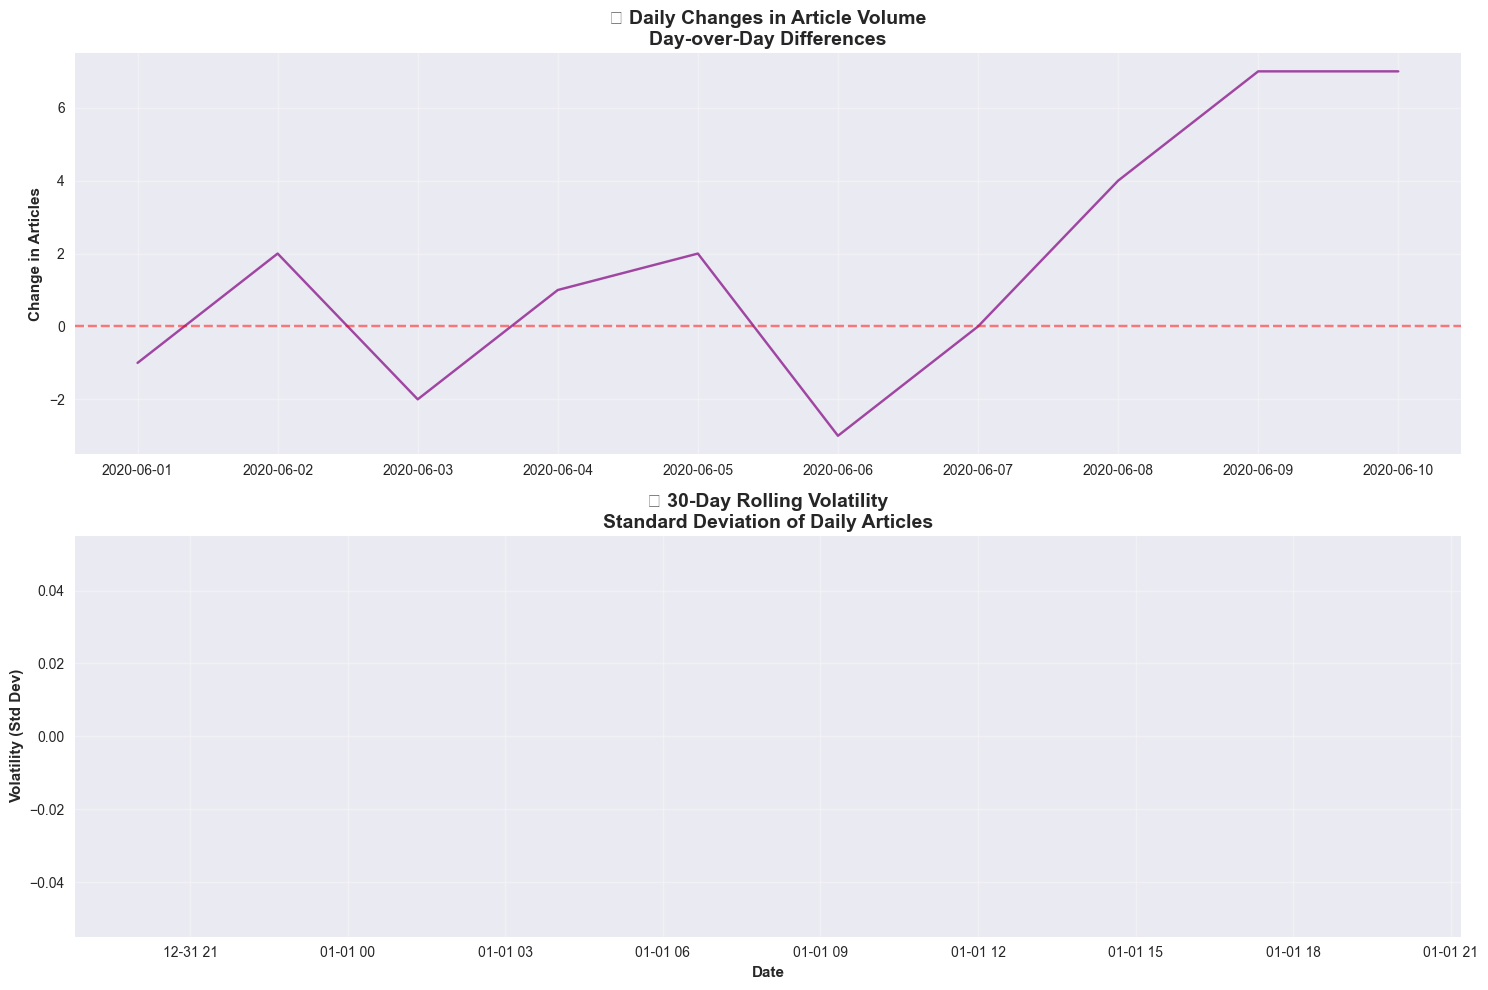

📊 Volatility Analysis:
   • Average daily change: 1.70 articles
   • Volatility (std of changes): 3.47
   • Maximum increase: 7.0 articles
   • Maximum decrease: -3.0 articles
   • Days with no change: 1 (9.1%)


In [19]:
# %%
# Volatility and change point analysis
print("\n📈 VOLATILITY AND CHANGE POINT ANALYSIS")
print("=" * 70)

# Calculate daily changes and volatility
daily_changes = daily_articles.diff()
rolling_volatility = daily_articles.rolling(window=30).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Daily changes
ax1.plot(daily_changes.index, daily_changes.values, alpha=0.7, color='purple')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('📊 Daily Changes in Article Volume\nDay-over-Day Differences', fontsize=14, fontweight='bold')
ax1.set_ylabel('Change in Articles', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Rolling volatility
ax2.plot(rolling_volatility.index, rolling_volatility.values, color='orange', linewidth=2)
ax2.set_title('📈 30-Day Rolling Volatility\nStandard Deviation of Daily Articles', fontsize=14, fontweight='bold')
ax2.set_ylabel('Volatility (Std Dev)', fontweight='bold')
ax2.set_xlabel('Date', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Volatility statistics
print(f"📊 Volatility Analysis:")
print(f"   • Average daily change: {daily_changes.mean():.2f} articles")
print(f"   • Volatility (std of changes): {daily_changes.std():.2f}")
print(f"   • Maximum increase: {daily_changes.max()} articles")
print(f"   • Maximum decrease: {daily_changes.min()} articles")
print(f"   • Days with no change: {(daily_changes == 0).sum()} ({(daily_changes == 0).mean()*100:.1f}%)")

In [20]:
# %% [markdown]
# ## 🎯 Time Series Insights & Forecasting Readiness

In [21]:
# %%
# Generate time series insights
print("\n🎯 TIME SERIES INSIGHTS & FORECASTING READINESS")
print("=" * 70)

# Insight 1: Seasonality patterns
monthly_avg = df_reset.groupby('month').size()
peak_month = monthly_avg.idxmax()
trough_month = monthly_avg.idxmin()

print(f"📅 SEASONALITY INSIGHTS:")
print(f"   • Peak publication month: {peak_month} ({monthly_avg.max():.0f} articles avg)")
print(f"   • Lowest publication month: {trough_month} ({monthly_avg.min():.0f} articles avg)")
print(f"   • Seasonality strength: {(monthly_avg.max() - monthly_avg.min()) / monthly_avg.mean() * 100:.1f}% variation")

# Insight 2: Trend analysis
from scipy.stats import linregress

# Calculate linear trend
x = np.arange(len(monthly_articles))
y = monthly_articles.values
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_strength = "STRONG" if abs(r_value) > 0.7 else "MODERATE" if abs(r_value) > 0.3 else "WEAK"
trend_direction = "INCREASING" if slope > 0 else "DECREASING"

print(f"\n📈 TREND ANALYSIS:")
print(f"   • Overall trend: {trend_direction} (slope: {slope:.4f})")
print(f"   • Trend strength: {trend_strength} (R²: {r_value**2:.3f})")
print(f"   • Trend significance: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} (p-value: {p_value:.4f})")

# Insight 3: Volatility patterns
high_volatility_periods = (rolling_volatility > rolling_volatility.quantile(0.75)).sum()
low_volatility_periods = (rolling_volatility < rolling_volatility.quantile(0.25)).sum()

print(f"\n📊 VOLATILITY INSIGHTS:")
print(f"   • High volatility periods: {high_volatility_periods} days")
print(f"   • Low volatility periods: {low_volatility_periods} days")
print(f"   • Volatility clustering: {'PRESENT' if high_volatility_periods > low_volatility_periods else 'NOT PROMINENT'}")

# Insight 4: Company-specific patterns
company_growth_rates = {}
for company in TICKERS:
    company_data = df[df['stock'] == company]
    company_monthly = company_data.resample('M').size()
    if len(company_monthly) > 1:
        growth_rate = (company_monthly.iloc[-1] - company_monthly.iloc[0]) / company_monthly.iloc[0] * 100
        company_growth_rates[company] = growth_rate

fastest_growing = max(company_growth_rates, key=company_growth_rates.get) if company_growth_rates else "N/A"
slowest_growing = min(company_growth_rates, key=company_growth_rates.get) if company_growth_rates else "N/A"

print(f"\n🏢 COMPANY GROWTH INSIGHTS:")
print(f"   • Fastest growing coverage: {fastest_growing} ({company_growth_rates.get(fastest_growing, 0):.1f}%)")
print(f"   • Slowest growing coverage: {slowest_growing} ({company_growth_rates.get(slowest_growing, 0):.1f}%)")

print(f"\n🎯 FORECASTING RECOMMENDATIONS:")
print(f"   1. Use {trend_strength.lower()} trend component in models")
print(f"   2. Incorporate seasonal patterns (peak in month {peak_month})")
print(f"   3. Model volatility clustering for risk assessment")
print(f"   4. Focus on {fastest_growing} for growth-oriented analysis")
print(f"   5. Consider ARIMA/SARIMA models for time series forecasting")


🎯 TIME SERIES INSIGHTS & FORECASTING READINESS
📅 SEASONALITY INSIGHTS:
   • Peak publication month: 6 (39 articles avg)
   • Lowest publication month: 5 (1 articles avg)
   • Seasonality strength: 190.0% variation

📈 TREND ANALYSIS:
   • Overall trend: INCREASING (slope: 38.0000)
   • Trend strength: STRONG (R²: 1.000)
   • Trend significance: SIGNIFICANT (p-value: 0.0000)

📊 VOLATILITY INSIGHTS:
   • High volatility periods: 0 days
   • Low volatility periods: 0 days
   • Volatility clustering: NOT PROMINENT

🏢 COMPANY GROWTH INSIGHTS:
   • Fastest growing coverage: NVDA (800.0%)
   • Slowest growing coverage: NVDA (800.0%)

🎯 FORECASTING RECOMMENDATIONS:
   1. Use strong trend component in models
   2. Incorporate seasonal patterns (peak in month 6)
   3. Model volatility clustering for risk assessment
   4. Focus on NVDA for growth-oriented analysis
   5. Consider ARIMA/SARIMA models for time series forecasting


In [22]:
# %%
# Save time series analysis results
print("\n💾 SAVING TIME SERIES ANALYSIS RESULTS...")
os.makedirs('../data/processed', exist_ok=True)

# Save daily time series data
daily_articles_df = pd.DataFrame({
    'total_articles': daily_articles,
    'rolling_7d': daily_articles.rolling(window=7).mean(),
    'rolling_30d': daily_articles.rolling(window=30).mean()
})
daily_articles_df.to_csv('../data/processed/03_daily_time_series.csv')

# Save company-wise time series
daily_articles_by_company.to_csv('../data/processed/03_company_daily_series.csv')

print("✅ Time series results saved:")
print("   - ../data/processed/03_daily_time_series.csv")
print("   - ../data/processed/03_company_daily_series.csv")

print("\n" + "="*70)
print("🎉 TIME SERIES ANALYSIS COMPLETE! Proceed to 04_publisher_analysis.ipynb")
print("="*70)


💾 SAVING TIME SERIES ANALYSIS RESULTS...
✅ Time series results saved:
   - ../data/processed/03_daily_time_series.csv
   - ../data/processed/03_company_daily_series.csv

🎉 TIME SERIES ANALYSIS COMPLETE! Proceed to 04_publisher_analysis.ipynb
